## Sequntial maximum likelihood estimation of infection rate parameters of a single PHU using negative Binomial 

In [25]:

import numpy as np
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import math

from scipy.optimize import minimize

##### CHANGE HERE #############
### Use the time up to which you need to estimate the parameters of sigmoid
dt = 0.1
tstart = 0
tlim = 35
t = np.arange(tstart, tlim, 1)

tmoh = np.arange(tstart, tlim, dt)

ndiv = 1/dt


##### CHANGE HERE #############

###### If you have your own data, load it here #######
### Currently loaded infection data from MOH, for April 2020 to March 2021

PHU_path = './../../../PHU_Data/'
Data = np.zeros([365,4])

files = os.listdir(PHU_path)

target_file1 = f'{PHU_path}/30-Toronto.csv'
target_file2 = f'{PHU_path}/34-York.csv'
target_file3 = f'{PHU_path}/04-Durham.csv'
target_file4 = f'{PHU_path}/22-PeelRegion.csv'

Data[:,0] = np.genfromtxt(target_file1, delimiter=',')
Data[:,1] = np.genfromtxt(target_file2, delimiter=',')
Data[:,2] = np.genfromtxt(target_file3, delimiter=',')
Data[:,3] = np.genfromtxt(target_file4, delimiter=',')


population_by_phu = np.genfromtxt(f'{PHU_path}/population_by_phu.csv', delimiter=',')


N_city = 1
# Preallocate compartments
S = np.zeros((len(tmoh),N_city))
E = np.zeros((len(tmoh),N_city))
I = np.zeros((len(tmoh),N_city))
R = np.zeros((len(tmoh),N_city))
D = np.zeros((len(tmoh),N_city))
N = np.zeros((len(tmoh),N_city))


I_model = np.zeros((len(t),N_city))
I_synthetic = np.zeros((len(t),N_city))

##### CHANGE HERE #############
## Observed data

### MOH data - No true solution
# I_synthetic[:,0] =  Data[tstart:tlim,2]

### Synthetic data - true solution
file = np.loadtxt('./toronto_synthetic_data.csv')
I_synthetic[:,0] = file[0:len(t)]

##############################

L_Force = np.zeros((len(tmoh),N_city))

##### CHANGE HERE #############
total = population_by_phu[29,1]
##### CHANGE HERE #############

 
##### CHANGE HERE #############
E[0,0] = Data[0,0]
I[0,0] = Data[0,0]
##############################
R[0,0] = 0
D[0,0] = 0
N[0,0] = total
S[0,0] = N[0,0] - E[0,0] - I[0,0] - R[0,0] - D[0,0]
I_model[0,0] = I[0,0]


# Model parameters - Taken from Southern Ontario - COVID MBE paper
gamma_e = 1/15
gamma_i = 1/5
gamma_r = 1/11
gamma_d = 1/750

beta_e = np.zeros((len(tmoh),N_city)) 
beta_i = np.zeros((len(tmoh),N_city))

beta_calibrated = np.zeros((len(tmoh),N_city))


print("initial infected",I[0,0])

print("total population",total)


#### PEEL - 234 , 1451022

#### Toronto - 430 , 2794356

### York - 212, 1173334

### Durham - 94   - 696992


mpl.rcParams.update({'font.size':14})




initial infected 430.0
total population 2794356.0


In [28]:

################### Durham ##########################################################
nparam = 1
param = np.ones(nparam)
##### CHANGE HERE ############
### Use the parameters which needs to be included in the sum of sigmoids model for MLE estimation
### When doing sequential calibration, include all the parameters until that time which are already calibrated. 

### Initial guesses of your parameters
a0 = 0.146  
a1 = -0.05
t1 =  20
# a2 =   0.02
# t2 =  35
# a3 =   -0.01
# t3 = 65
# a4 =  0.02
# t4 = 90
# a5 =  0.04
# t5 = 140
# a6 =  -0.05
# t6 = 180
# a7 =  0.05
# t7 = 190
# a8 =  -0.03
# t8 = 250

### Manually Tuned parameters for MOH infection data

# a0 =   0.14
# a1 =  -0.115
# t1 =  20
# a2 =   0.06
# t2 =  35
# a3 =   -0.05
# t3 = 65
# a4 =  0.035
# t4 = 90
# a5 =  0.06
# t5 = 140
# a6 =  -0.075
# t6 = 180
# a7 =  0.06
# t7 = 190
# a8 =  -0.025
# t8 = 250


### CHANGE HERE 
beta_i[:,0] = a0  + a1/(1 + np.exp((t1-tmoh)))  
# +  a2/(1 + np.exp((t2-tmoh))) 
# + a3/(1 + np.exp((t3-tmoh))) 
# + a4/(1 + np.exp((t4-tmoh))) 
# + a5/(1 + np.exp((t5-tmoh)))  
# + a6/(1 + np.exp((t6-tmoh))) 
# + a7/(1 + np.exp((t7-tmoh))) 
# + a8/(1 + np.exp((t8-tmoh)))

beta_e[:,0] = beta_i[:,0]



#### DEFINE THE PARAMETERS TO BE ESTIMATED 

### CHANGE HERE 
param = np.array([a1])






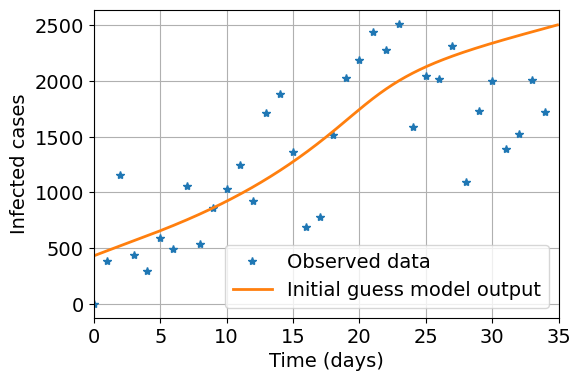

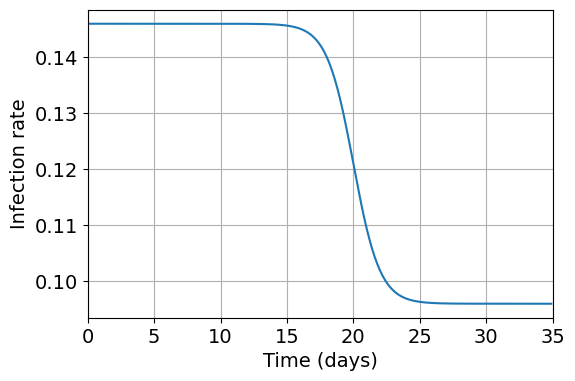

In [29]:
 

FoI = np.zeros((len(tmoh),1))
    
for kk in range(1,len(tmoh)):

  FoI[kk,0] = beta_e[kk-1,0] * (E[kk-1,0] + I[kk-1,0]) / N[kk-1,0]

  S[kk,0] = S[kk-1,0] + dt*(- FoI[kk,0] * S[kk-1,0])
  E[kk,0] = E[kk-1,0] + dt*(FoI[kk,0]*S[kk-1,0] - (gamma_i + gamma_e)*E[kk-1,0])
  
  I[kk,0] = I[kk-1,0] + dt*(gamma_i*E[kk-1,0] - (gamma_r + gamma_d)*I[kk-1,0])
  R[kk,0] = R[kk-1,0] + dt*(gamma_e*E[kk-1,0] + gamma_r*I[kk-1,0])
  D[kk,0] = D[kk-1,0] + dt*(gamma_d*I[kk-1,0])
  N[kk,0] = S[kk,0] +  E[kk,0] + I[kk,0] + R[kk,0]

  if( kk%ndiv == 0):
      idxmoh = int(kk/ndiv)
      I_model[idxmoh,0] = I[kk,0]



fig1, ax1 = plt.subplots(figsize=(6, 4))
ax1.set_xlim([0,tlim])
ax1.set_xlabel('Time (days)')
ax1.set_ylabel('Infected cases') 
ax1.grid()
plt.plot(t, I_synthetic[tstart:tlim,0], '*', markersize=6, label='Observed data')
plt.plot(tmoh, I[:,0], '-',linewidth=2, label='Initial guess model output')
ax1.legend(loc='best')
# plt.savefig('./figs/noisy_data.pdf',  bbox_inches='tight')
plt.show()



fig2, ax2 = plt.subplots(figsize=(6, 4))
ax2.set_xlim([0,tlim])
ax2.set_xlabel('Time (days)')
ax2.set_ylabel('Infection rate') 
ax2.grid()
plt.plot(tmoh, beta_i[:,0], label='Sum of sigmoid model')
ax1.legend(loc='best')
# plt.savefig('./figs/beta.pdf',  bbox_inches='tight')
plt.show()




### Applying scipy optimization library

In [30]:

#### CHANGE HERE 
### decrease p to reduce r and thus dispersion, increase p to get more dispersion
p = 0.005 # probability of success


def loglikelihood(param):
      
    idxmoh = 1

    loglik = 0

    FoI = np.zeros((len(tmoh),1))

############### CHANGE HERE #################
###### Update the model of beta to include the parameter which needs to be estimated along with the known paramters until that time
    beta_i[:,0] = a0 + param[0]/(1 + np.exp((t1-tmoh))) 
    
    # param[0] + param[1]/(1 + np.exp((t1-tmoh))) 
    #   + param[0]/(1 + np.exp((t2-tmoh)))  
    # + param[0]/(1 + np.exp((t3-tmoh))) 
    #  + param[0]/(1 + np.exp((t4-tmoh)))
    #  + param[0]/(1 + np.exp((t5-tmoh))) 
    # + param[0]/(1 + np.exp((t6-tmoh))) 
    # + param[0]/(1 + np.exp((t7-tmoh))) 
    # + param[0]/(1 + np.exp((t8-tmoh)))
    

    beta_e[:,0] = beta_i[:,0]   

    for kk in range(1,len(tmoh)):

            FoI[kk,0] = beta_e[kk-1,0] * (E[kk-1,0] + I[kk-1,0]) / N[kk-1,0]

            S[kk,0] = S[kk-1,0] + dt*(- FoI[kk,0] * S[kk-1,0])
            E[kk,0] = E[kk-1,0] + dt*(FoI[kk,0]*S[kk-1,0] - (gamma_i + gamma_e)*E[kk-1,0])
            I[kk,0] = I[kk-1,0] + dt*(gamma_i*E[kk-1,0] - (gamma_r + gamma_d)*I[kk-1,0])
            R[kk,0] = R[kk-1,0] + dt*(gamma_e*E[kk-1,0] + gamma_r*I[kk-1,0])
            D[kk,0] = D[kk-1,0] + dt*(gamma_d*I[kk-1,0])
            N[kk,0] = S[kk,0] +  E[kk,0] + I[kk,0] + R[kk,0]


            ## For collecting the model output only at data points
            if( kk%ndiv == 0 ):
                idxmoh = int(kk/ndiv)

           ### CAREFUL  - have to use -ve log likelihood

            if int(I_synthetic[idxmoh]) == 0:
                        logNfac = 0.0
            else:
                logNfac = np.sum(np.log(np.arange(0,int(I_synthetic[idxmoh]),1)+1)) #log factorial
                r = (p*I[kk,0])/(1-p)
                loglik = loglik + (math.lgamma(I_synthetic[idxmoh]+r) - (logNfac + math.lgamma(r)) + r*np.log(p) + I_synthetic[idxmoh]*np.log(1-p))

    
    return -loglik



options_bfgs = {
    'gtol': 1e-12,  # Gradient norm tolerance for convergence
    'disp': True,  # Display convergence messages
    'eps': 1e-8
}

options_nm = {
    'disp': True,  # Display convergence messages
}



### To be used for Synthetic data when you know true parameter values
# errors = []
# iterations = []

# def callback(xk):
#     print(f"Current parameter values: {xk}")
#     # err = np.linalg.norm(xk - trueparam)/np.linalg.norm(trueparam)
#     # print("relative error is", err)
#     errors.append(err)
#     iterations.append(len(errors))
 


res = minimize(loglikelihood, param,method='L-BFGS-B', options = options_bfgs)

# res = minimize(loglikelihood, param,method='Nelder-Mead',bounds=bounds, options=options_nm)

### To be used for Synthetic data when you know true parameter values
# path = './figs'
# filepath =  os.path.join(path,'relative_error.pdf')
# # Plot the error vs iteration
# # plt.figure()
# # plt.plot(iterations, errors, marker='o')
# # plt.xlabel('Iteration')
# # plt.ylabel('Relative error norm')
# # # plt.title('Relative error norm vs iteration')
# # plt.grid(True)
# # plt.savefig(filepath)
# # plt.show()


print(res)
param_mle = res.x

print("initial guesses" ,param)
print("MLE value", res.x)

        

/var/folders/lr/4h04vl_92s3d0hrwg37l8g740000gn/T/ipykernel_26824/1864093332.py:48: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  if int(I_synthetic[idxmoh]) == 0:
/var/folders/lr/4h04vl_92s3d0hrwg37l8g740000gn/T/ipykernel_26824/1864093332.py:51: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  logNfac = np.sum(np.log(np.arange(0,int(I_synthetic[idxmoh]),1)+1)) #log factorial
/var/folders/lr/4h04vl_92s3d0hrwg37l8g740000gn/T/ipykernel_26824/1864093332.py:53: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this ope

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            1     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.61576D+03    |proj g|=  2.36475D+03

At iterate    1    f=  2.58374D+03    |proj g|=  4.64700D+02

At iterate    2    f=  2.58166D+03    |proj g|=  1.36841D+02

At iterate    3    f=  2.58149D+03    |proj g|=  1.33699D+01

At iterate    4    f=  2.58148D+03    |proj g|=  3.37332D-01
  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: 2581.483906655245
        x: [-8.208e-02]
      nit: 5
      jac: [-5.457e-04]
     nfev: 16
     njev: 8
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
initial guesses [-0.05]
MLE value [-0.0820841]

At iterate    5    f=  2.58148D+03    |proj g|=  5.45697D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauch

### MLE Fit

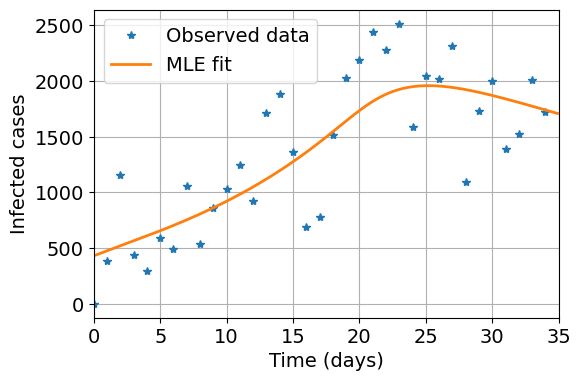

In [31]:



########### CHANGE HERE #############
### Add the necessary parameter values which are already calibrated along with the current parameters ##############

beta_i[:,0] = a0 +  param_mle[0]/(1 + np.exp((t1-tmoh)))  
# + param_mle[0]/(1 + np.exp((t2-tmoh))) 
# + param_mle[0]/(1 + np.exp((t3-tmoh))) 
# + param_mle[0]/(1 + np.exp((t4-tmoh))) 
# + param_mle[0]/(1 + np.exp((t5-tmoh))) 
# + param_mle[0]/(1 + np.exp((t6-tmoh))) 
# + param_mle[0]/(1 + np.exp((t7-tmoh))) 
# + param_mle[0]/(1 + np.exp((t8-tmoh)))



###########################################

beta_e[:,0] = beta_i[:,0]
 

FoI = np.zeros((len(tmoh),1))
    
for kk in range(1,len(tmoh)):

  FoI[kk,0] = beta_e[kk-1,0] * (E[kk-1,0] + I[kk-1,0]) / N[kk-1,0]

  S[kk,0] = S[kk-1,0] + dt*(- FoI[kk,0] * S[kk-1,0])
  E[kk,0] = E[kk-1,0] + dt*(FoI[kk,0]*S[kk-1,0] - (gamma_i + gamma_e)*E[kk-1,0])
  
  I[kk,0] = I[kk-1,0] + dt*(gamma_i*E[kk-1,0] - (gamma_r + gamma_d)*I[kk-1,0])
  R[kk,0] = R[kk-1,0] + dt*(gamma_e*E[kk-1,0] + gamma_r*I[kk-1,0])
  D[kk,0] = D[kk-1,0] + dt*(gamma_d*I[kk-1,0])
  N[kk,0] = S[kk,0] +  E[kk,0] + I[kk,0] + R[kk,0]


fig1, ax1 = plt.subplots(figsize=(6, 4))
plt.plot(t[:tlim], I_synthetic[:tlim,0], '*', markersize=6, label='Observed data')
plt.plot(tmoh[:int(tlim*ndiv)], I[:int(tlim*ndiv),0], '-',linewidth=2, label='MLE fit')
plt.legend(loc='best')
plt.xlabel('Time (days)')
plt.xlim([0,tlim])
plt.ylabel('Infected cases')
plt.grid()
plt.savefig('./figs/MLE_fit.pdf', bbox_inches='tight')
plt.show()
